## DistillBERT Fine-Tune

### Original Dataset (headlines)

In [2]:
import tensorflow as tf
import os
import zipfile
import pandas as pd
import numpy as np
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForSequenceClassification

In [2]:
path="./Sarcasm_Headlines_Dataset.json"
data = pd.read_json(path, lines=True)
labels = data.is_sarcastic.values
sentences = data.headline.values
data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [3]:
from sklearn.model_selection import train_test_split
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased', do_lower_case = True)

def encoder(length, sentences):
  ids = []
  for sentence in sentences:
    encoding = tokenizer.encode_plus(
    sentence,
    max_length = length,
    truncation = True,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=False)
    ids.append(encoding['input_ids'])
  return ids

#Train test split
train_sentences,test_sentences, train_labels, test_labels = train_test_split(sentences,labels,test_size=0.15)

train_ids = encoder(16, train_sentences)
test_ids = encoder(16, test_sentences)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

D:\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2263: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [4]:
train_ids = tf.convert_to_tensor(train_ids)
test_ids = tf.convert_to_tensor(test_ids)
test_labels = tf.convert_to_tensor(test_labels)
train_labels = tf.convert_to_tensor(train_labels)

In [9]:
from transformers import TFDistilBertModel
# distillbert_encoder = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
distillbert_encoder = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_projector', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [10]:
input_word_ids = tf.keras.Input(shape=(16,), dtype=tf.int32, name="input_word_ids")
embedding = distillbert_encoder([input_word_ids])
dense = tf.keras.layers.Lambda(lambda seq: seq[:, 0, :])(embedding[0])
dense = tf.keras.layers.Dense(128, activation='relu')(dense)
dense = tf.keras.layers.Dropout(0.2)(dense)
output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=[input_word_ids], outputs=output)

In [11]:
model.compile(tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 16)]             0         
                                                                 
 tf_distil_bert_model (TFDis  TFBaseModelOutput(last_h  66362880 
 tilBertModel)               idden_state=(None, 16, 7            
                             68),                                
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 lambda_2 (Lambda)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 128)               98432     
                                                                 
 dropout_59 (Dropout)        (None, 128)               0     

In [12]:
history = model.fit(x = train_ids, y = train_labels, epochs = 3, verbose = 1, batch_size = 32, validation_data = (test_ids, test_labels))

Epoch 1/3
710/710 [==============================] - 859s 1s/step - loss: 0.3203 - accuracy: 0.8598 - val_loss: 0.2263 - val_accuracy: 0.9087

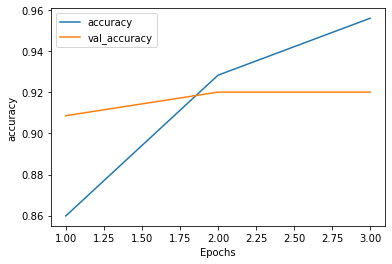

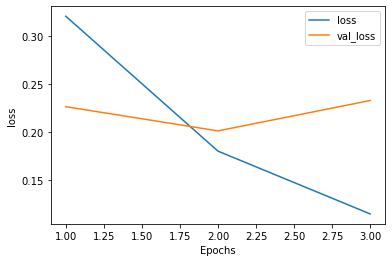

In [24]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot([1,2,3], history.history[string])
  plt.plot([1,2,3], history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

### Newly Crawled Dataset (Intros + headlines)

In [13]:
new_path='./Sarcasm_News_Dataset_handled_cut.json'
new_data = pd.read_json(open(new_path, 'r', encoding="utf8"), lines=True)
intros = new_data.intro.values
headlines = new_data.headline.values
for i in range(len(intros)):
  if intros[i] == '':
    intros[i] = headlines[i]
labels = new_data.is_sarcastic.values
new_data.head()

,article_link,headline,is_sarcastic,intro
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0,An encrypted message was used to alert staff a...
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0,"What begins with an unrefined, heavy-handed to..."
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1,"WHITE PLAINS, NYWith still no indication that ..."
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1,WASHINGTONAmid the continuing debate over the ...
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0,"Many happy returns, you old half-blood Prince."


In [16]:
from sklearn.model_selection import train_test_split
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased', do_lower_case = True)

def encoder(length, sentences):
  ids = []
  for sentence in sentences:
    encoding = tokenizer.encode_plus(
    sentence,
    max_length = length,
    truncation = True,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=False)
    ids.append(encoding['input_ids'])
  return ids

#Train test split
train_intros, test_intros, train_labels, test_labels = train_test_split(intros,labels,test_size=0.15)

train_ids = encoder(60, train_intros)
test_ids = encoder(60, test_intros)

D:\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2263: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [17]:
train_ids = tf.convert_to_tensor(train_ids)
test_ids = tf.convert_to_tensor(test_ids)
test_labels = tf.convert_to_tensor(test_labels)
train_labels = tf.convert_to_tensor(train_labels)

In [19]:
from transformers import TFDistilBertModel
distillbert_encoder = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [21]:
input_word_ids = tf.keras.Input(shape=(60,), dtype=tf.int32, name="input_word_ids")
embedding = distillbert_encoder([input_word_ids])
dense = tf.keras.layers.Lambda(lambda seq: seq[:, 0, :])(embedding[0])
dense = tf.keras.layers.Dense(128, activation='relu')(dense)
dense = tf.keras.layers.Dropout(0.2)(dense)
output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=[input_word_ids], outputs=output)

In [22]:
model.compile(tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 60)]             0         
                                                                 
 tf_distil_bert_model (TFDis  multiple                 66362880  
 tilBertModel)                                                   
                                                                 
 lambda_1 (Lambda)           (None, 768)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               98432     
                                                                 
 dropout_20 (Dropout)        (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                           

In [23]:
history = model.fit(x = train_ids, y = train_labels, epochs = 3, verbose = 1, batch_size = 32, validation_data = (test_ids, test_labels))

Epoch 1/3
710/710 [==============================] - 2822s 4s/step - loss: 0.1791 - accuracy: 0.9218 - val_loss: 0.1175 - val_accuracy: 0.9488

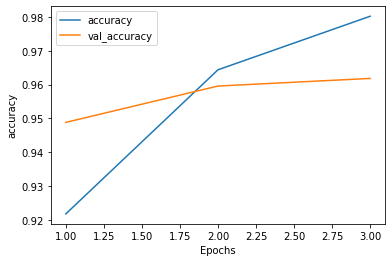

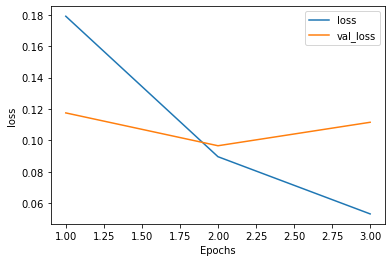

In [24]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot([1,2,3], history.history[string])
  plt.plot([1,2,3], history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')